Copyright 2019 The TensorFlow Authors.

이 노트북은 구글의 transformer 튜토리얼을 가져온 것입니다.

source from : https://www.tensorflow.org/tutorials/text/transformer


# Transformer model for language understanding

Transformer Paper - Attention is All You Need : https://arxiv.org/abs/1706.03762

이 노트북은 포르투갈어를 영어로 번역하는 Transformer 모델에 대한 설명입니다. Text Generation 과 Attention 에 대한 기본 이해를 필요로 합니다.

Transformer 모델의 핵심 아이디어는 Self-Attention 입니다. Self Attention 은 다른 위치의 입력 시퀀스를 계산하여 표현하는 방법입니다. Transformer 는 Self Attention 레이어들을 쌓아 생성됩니다. 

Transformer 모델은 다양한 크기의 입력을 RNN 이나 CNN 대신 self attention 레이어들을 이용하여 처리합니다. 이런 구조의 장점은
- 데이터들의 일시적인 / 공간적인 관계에 구애받지 않습니다. 이것은 object 들의 처리에 이상적입니다 
- 레이어들의 출력값들이 평행적으로(동시에) 처리 가능합니다. (RNN 같은 series 는 불가능)
- 다수의 RNN 이나 Conv 레이어들을 통하지 않아도 멀리 떨어진 값들에 영향을 미칠수 있습니다.
- 멀리 떨어져 있는 데이터들의 의존관계에 대해 학습할 수 있습니다. 이건 많은 Sequence 문제들의 난제였습니다

Transformer 모델의 단점은,
- 시계열(time-series) 데이터의 경우, 각 시기의 출력값은 입력값과 hidden-state 으로 계산되는 대신 전체적인 기록으로 계산됩니다.
- 만약 입력값에 일시적인 / 공간적인 관계가 있다면 (문자열처럼) 위치값이 추가되어야 합니다.

## 패키지 로드

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow_datasets as tfds

import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.version.VERSION

'2.1.0'

In [3]:
# GPU load 문제가 생길때
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

Num GPUs Available:  1


## 입력 Pipeline

###  Data Load

TFDS 에서 포르투갈어 - 영어 번역 데이터를 가져옵니다.

약 50000개의 학습 데이터와 1100개의 검증 데이터, 2000개의 테스트 데이터가 있습니다.

In [4]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

### subwords Tokenizer

TFDS 에서 제공

In [5]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

Tokenizer + Encoding 테스트

In [6]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


In [7]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7877 ----> .


### 배치 사이즈 / 버퍼 사이즈 정의

In [8]:
BUFFER_SIZE = 20000
BATCH_SIZE = 128

### Start / End 토큰을 입력, 출력 값에 넣어주기 위해 공간 추가

In [9]:
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
        lang1.numpy()) + [tokenizer_pt.vocab_size+1]

    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
        lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
    return lang1, lang2

Dataset.map 을 사용하여 위의 함수를 적용할 수 있지만, Dataset.map 은 그래프 모드로 실행되기 때문에 tensorflow 함수만 사용 가능합니다.

따라서 .map 을 바로 사용할 수 없고, tf.py_function 을 사용해야 합니다.

In [10]:
def tf_encode(pt, en):
    result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
    result_pt.set_shape([None])
    result_en.set_shape([None])

    return result_pt, result_en

**학습 속도를 빠르게 하기 위해 40개 이상의 토큰은 제거하여 학습합니다 (그대로 해야 성능은 더 잘 나옵니다)**

In [11]:
MAX_LENGTH = 40

In [12]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                           tf.size(y) <= max_length)

In [13]:
# Map, filter 를 이용하여 tf_encode, maxlenght 적용합니다
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)

# 데이터셋을 메모리에 캐시하여 읽기 속도를 빠르게 합니다.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(batch_size = BATCH_SIZE, padded_shapes=([None],[None]))
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 검증 데이터셋에도 적용해줍니다.
val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE,  padded_shapes=([None],[None]))

In [14]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(128, 40), dtype=int64, numpy=
 array([[8214, 1259,    5, ...,    0,    0,    0],
        [8214,  299,   13, ...,    0,    0,    0],
        [8214,   59,    8, ...,    0,    0,    0],
        ...,
        [8214,  119,    1, ...,    0,    0,    0],
        [8214,   24,  684, ...,    0,    0,    0],
        [8214, 3169,    3, ...,    0,    0,    0]], dtype=int64)>,
 <tf.Tensor: shape=(128, 40), dtype=int64, numpy=
 array([[8087,   18,   12, ...,    0,    0,    0],
        [8087,  634,   30, ...,    0,    0,    0],
        [8087,   16,   13, ...,    0,    0,    0],
        ...,
        [8087,   18,   12, ...,    0,    0,    0],
        [8087,   19,    8, ...,    0,    0,    0],
        [8087, 4658,  354, ...,    0,    0,    0]], dtype=int64)>)

## Positional encoding - 위치 인코딩

Transformer 모델은 RNN 이나 CONV 을 포함하지 않기 때문에 문장의 단어들의 위치 관계 데이터를 인코딩 하여 추가해야 합니다.

이 위치 인코딩 데이터는 임베딩 벡터에 추가됩니다. 

임베딩은 비슷한 의미의 토큰일수록 더 가까이 있는 D-차원의 공간을 표현합니다.

하지만 임베딩은 한 문장의 단어들의 위치 관계를 인코드 하지는 않습니다. 따라서 위치 인코딩을 추가한 뒤에는,
1. 의미가 비슷하고 
2. 한 문장에서 가까이 위치한

단어들은 D-차원의 공간에서 더 가까워지게 됩니다.

Positional Encoding (위치 인코딩) 에 대한 노트북<br />
https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb

위치 데이터를 계산하는 공식은


$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

### positional encoding 계산

In [15]:
# 위의 위치 데이터 공식대로 계산하는 함수

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [16]:
def positional_encoding(position, d_model):
    # 위의 공식으로 PE (positional encoding) 값 구하기
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
  
    # apply sin to even indices in the array; 2i
    # 2i (짝수) 에는 sin 값 적용
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    # 2i+1 (홀수) 에는 cos 값 적용
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    # sin / cos 값 적용한것 붙임
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


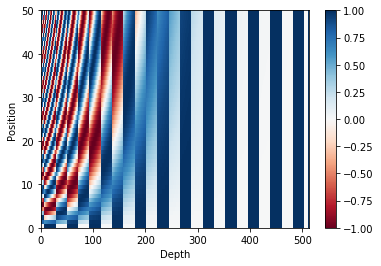

In [17]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

모델이 padding 을 입력값으로 여기지 않게 하기 위하여 모든 Pad 토큰들을 mask 합니다.

Pad 값이 0 이면 mask 이기 때문에 1을 출력합니다. 아니면 0 을 출력합니다.


In [18]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [19]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

### Look ahead mask

Look-ahead mask 는 다음 토큰들을 mask 해주기 위해 사용됩니다. 어떤 입력값들이 사용되지 않을지 나타내는곳에 사용된다는 뜻입니다.

예를들어, 3번째 단어를 예측할때는 오직 1,2 번째 단어만 사용한다는 뜻입니다.

### band_part
tf.linalg.band_part : 
https://www.tensorflow.org/api_docs/python/tf/linalg/band_part

tf.linalg.band_part (input, mum_lower, num_max)

num_lower 은 유지할 subdiagonal 갯수, num_max 는 유지할 superdiagonal 갯수

matrix 가 아래와 같을때

a,b,c<br />
d,e,f<br />
g,h,i

subdiagonal : [g], [d,h] ... 왼쪽 아래부터 시작하는 대각선<br />
superdiagonal : [c], [b,f] ... 오른쪽 위부터 시작하는 대각선을 뜻함

In [20]:
def create_look_ahead_mask(size):
    # SuperDiagonal 전부 제거
    # SubDiagonal 유지
    # 이후 1 에서 빼므로 0, 1 전환
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [21]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled Dot Product Attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

### 개념, 계산식

Transformer 에서 사용되는 Attention 함수는 3개의 입력값을 받습니다.<br />
Q (query), K (key), V (value) 입니다. <br />
Attention weight 을 계산하기 위해 사용되는 식은 아래와 같습니다.

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

Dot-product(내적) Attention 은 depth 의 루트값에 의해 scaled (크기값이 적용) 됩니다. Depth 의 루트값으로 scaling 하는 이유는, 내적값이 너무 커지면 softmax 의 gradient (경사도) 가 작아져서 softmax 를 적용하기 어려워 지기 때문입니다.

Mask 는 -1e9 (음의 무한값과 유사) 와 곱해집니다. 왜냐면 mask는 scaled matrix Q * K 과 합쳐지고, softmax 직전에 적용되기 때문입니다. Mask 의 목적은 이 셀들을 0 으로 제거하는것이기 때문에, 이 방식으로 아주 큰 음의 값으로 softmax 를 취해 0에 가까운 값이 나오게 합니다.

In [22]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.
                  
                  |
                  V
                  
      어텐션 weight 을 계산합니다.
      1. q k v 의 앞 부분의 차원이 같아야 합니다.
      2. k v 끝에서 두번째의 차원이 같아야 합니다.
      3. mask 의 유형에 따라 shape 이 다릅니다.
      4. 하지만 mask 는 더할수 있게 broadcastable 해야 합니다 (수식 계산이 가능하게 배열을 자동으로 변환)
         - 참고 : https://sacko.tistory.com/16
         
    Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.
    
    Returns:
        output, attention_weights
    """
    
    # Q 와 K transpose 의 내적 (dot product)
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
      
    # dk (k 의 depth) 계산
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    
    # scaled attention
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # scaled tensor 에 mask 추가
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # Softmax 는 마지막 axis 에서 정규화 되기 때문에 score의 합은 1입니다.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    
    # Attention weight 과 벡터의 곱
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

### 결과값의 의미

(As the softmax normalization is done on K, its values decide the amount of importance given to Q.)<br />
Softmax 의 정규화는 K 에서 되기때문에, 값은 주어진 Q값의 중요도에 따라 결정됩니다. (무슨 소리지..?)<br />

(... softmax 가 적용되는 대상이 Q 와 K transpose 의 내적값이기 때문에??)

출력값은 attention weight 과 V의 곱이기 때문에, 집중할 단어의 영향은 유지되고, 관계 없는 단어의 영향은 사라집니다.

### 계산 과정 확인

In [23]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
        q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

In [24]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# Query 가 2번째 key 와 연관있음.
# 따라서 2번째 value 가 리턴됨

temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

############### 계산 중간값들 Print

print('계산 과정을 출력 합니다')
# QK matmul
matmul_qk = tf.matmul(temp_q, temp_k, transpose_b=True)
print('{:18}'.format('QK^t'), ' :', matmul_qk)

# deep of k
dk = tf.cast(tf.shape(temp_k)[-1], tf.float32)
print('{:18}'.format('Deep K'), ' :',dk)

# scaled attention
scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
print('{:18}'.format('Scaled Attention'), ' :',scaled_attention_logits)


# attention weight
attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
print('{:18}'.format('attention_weights'), ' :',attention_weights)

# Attention weight 과 벡터의 곱
output = tf.matmul(attention_weights, temp_v)  # (..., seq_len_q, depth_v)
print('{:18}'.format('Output'), ' :',output)

print('')
print('Query 가 key 의 2번쨰 값과 연관있으므로, Attention weight 도 2번째 항에 1로, Output 도 2번째 key값으로 나옴')

계산 과정을 출력 합니다
QK^t                : tf.Tensor([[  0. 100.   0.   0.]], shape=(1, 4), dtype=float32)
Deep K              : tf.Tensor(3.0, shape=(), dtype=float32)
Scaled Attention    : tf.Tensor([[ 0.       57.735027  0.        0.      ]], shape=(1, 4), dtype=float32)
attention_weights   : tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output              : tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)

Query 가 key 의 2번쨰 값과 연관있으므로, Attention weight 도 2번째 항에 1로, Output 도 2번째 key값으로 나옴


Query를 3번째, 2번째, (1,2)번째 값과 연관시켜 weight 을 보면

In [25]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi Head Attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">

###  구조

Multi head attention 은 4개의 파트로 구성되어 있습니다.
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

### 개념

각각의 multi head attention 블럭은 3개의 입력값 ( Q K V ) 를 갖습니다. 이 값들은 Linear (Dense) layer 를 통해 들어가고, multi head 갯수만큼 나눠집니다.

`Scaled Dot Product Attention `은 각각의 head 에 적용됩니다. (효율성을 위해 broadcasted 됨). 적합한 `mask` 가 attention step 에 반드시 적용되어야 합니다. 각각의 attention output 값이 하나로 붙여져 마지막 `Dense Layer` 로 갑니다. (Concatenated)

한개의 attention head 를 쓰는 대신 여러개로 나누는 이유는, 여러개로 나눠서 행했을때 다른 표현 공간의 다른 위치에, 다양하게 집중할 수 있게 하기 때문입니다. 각 head를 나누는 것은 차원수를 낮춰 주기 때문에, 하나의 attention head 에 기존 차원의 입력을 사용하는것과 계산량은 같습니다.

### 구현

In [26]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        
        self.num_heads = num_heads
        self.d_model = d_model
        
        # Model 의 차원이 num_heads 로 나눠져야 제대로 나눠지므로 assert 함수 사용
        assert d_model % self.num_heads == 0
    
        # 한개의 head 의 depth 계산
        self.depth = d_model // self.num_heads
        
        # linear layer 정의
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
    
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """
            마지막 차원을 (num_heads, depth) 로 나눕니다
            값을 (batch_size, num_heads, seq_len, depth) 형태로 transpose 합니다.
        """
        
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
    
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
    
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        # concatenate 하기 위해 num_heads, depth 차원을 마지막으로
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
        return output, attention_weights

### 테스트

In [27]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point Wise Feed Forward network

Point wise feed forward network 는 2개의 Fully Connected Layers 로 구성되어있음

(point wise - 특정 값에 집중한?? 확인필요)

In [28]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [29]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder / Decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

### 기본 구조

Transformer 의 구조는 기존의 일반적인 Sequence to Sequence 구조와 같습니다.

- 입력된 문장은 N 개의 인코더 레이어를 지나 각각 토큰에 대해  output 시퀀스를 만듭니다.
- 인코더의 output 과 self-attention 을 통해 다음 단어를 예측합니다.

### 인코더 레이어

각각의 인코더 레이어는 하위 레이어들(sub layers) 로 이루어 집니다.

1. Multi Head Attention
2. Point wise Feed Forward networks

이 하위레이어들은 layer normalization 이 따라오는 잔여 연결(residual connection) 을 가지고 있습니다. 이 잔여 연결은 Vaninshing Gradient 문제를 피하는데 도움을 줍니다.

각 하위 레이어들의 출력값은 `LayerNorm(x + Sublayer(x))` 입니다. Normalization 은 마지막 axis 에 적용됩니다.N 은 Transformer 의 인코더 개수 입니다.

#### Residual Connection (Skip Connection)

<img src ="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5f/ResNets.svg/220px-ResNets.svg.png">

https://en.wikipedia.org/wiki/Residual_neural_network

Skip Connection 이라고 주로 불리는 방법. 몇개의 layer 들을 무시하고 다음 layer로 넘어가서 vanishing gradient 문제를 해결

#### 인코더 레이어 구현

In [30]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        
        # Skip Connection
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        
        # Skip Connection
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
        return out2

#### 인코더 레이어 테스트

In [31]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### 디코더 레이어

각각의 디코더 레이어는 하위 레이어들(sub layers) 로 이루어 집니다.

1. Masked Multi Head Attention (with `look ahead mask` and `padding mask`)
2. Multi Head Attention (with `padding mask`)
    - V, K 는 인코더의 리턴값을 디코더의 입력값으로 사용
    - Q 는 masked multi-head attention 으로부터 받음
    
    
3. Point Wise Feed Forward Networks

인코더와 마찬가지로 전부 Residual Connection 을 가지고 있습니다.

인코더와 같은 개수의(N) 디코더로 구성됩니다.

Q 를 디코더의 첫번째 attention 에서 받고, K 는 인코더의 리턴값에서 받으므로, Attention Weight 은 인코더의 리턴값을 기준으로 디코더 입력값의 중요도를 나타냅니다 = 디코더는 다음값을 예측할때, 인코더의 리턴값과 Self-Attention 리턴값을 사용합니다. 



####  디코더 레이어 구현

In [32]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)
 
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
    
        # enc_output.shape == (batch_size, input_seq_len, d_model)
    
        # 첫 Masked Multi Head Attention Block
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
    
        # 다음 Multi Head Attention Block
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
        # 마지막 Feed Forward 
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
        return out3, attn_weights_block1, attn_weights_block2

#### 디코더 레이어 테스트

In [33]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### 인코더

인코더는 3가지로 구성되어 있습니다.

1. Input Embedding
2. Positional Encoding
3. N Encoder layers

임베딩 값과 Positional Encoding 값을 더해서 Encoder Layer의 입력값으로 사용합니다.

#### 인코더 구현

In [34]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                   maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
    
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)
    
    
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
  
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]
    
        # Embedding + Positional Encoding
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x  # (batch_size, input_seq_len, d_model)

#### 인코더 테스트

In [35]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### 디코더

디코더는 3가지로 구성되어 있습니다.

1. Output Embedding
2. Positional Encoding
3. N Decoder layers

임베딩 값과 Positional Encoding 값을 더해서 Encoder Layer의 입력값으로 사용합니다.

#### 디코더 구현

In [36]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
    
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        # Embedding + Positional Encoding
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
    
        x = self.dropout(x, training=training)
        
        # Decoding Layers
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
      
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

#### 디코더 테스트

In [37]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Transformer

트랜스포머는 Encoder, Decoder, Final Linear Layer 로 구성됩니다.

### Transformer 구현

In [38]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
                target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
        return final_output, attention_weights

### Transformer Test

In [39]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

### Hyper Parameter

기본 Base Transformer 는

- num_layers = 6
- d_model = 512
- dff = 2048
- num_heads = 8

를 사용했지만, 빠른 학습을 위해 작은 파라미터 사용가능합니다.

In [40]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

EPOCHS = 20

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

### Optimizer with Custom Schedule

기본적으로 Adam Optimizer 를 사용했는데, learning rate 를 아래 수식에 따라 변화시켰습니다.

처음 학습하는 동안을 warm up 시기로 보고 linear 하게 learning rate 를 증가시켰고, warm up 이 끝나면 학습 횟수의 역제곱근만큼 감소시켰습니다.


$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [41]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
    
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
    
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [42]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

learning rate가 어떻게 변하는지 그래프로 표현하면 아래와 같습니다.

Text(0.5, 0, 'Train Step')

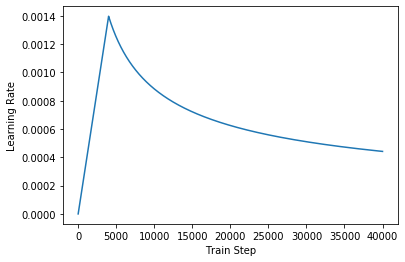

In [43]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Loss, Metrics

입력값에 Padding 이 포함되었기 때문에, padding mask 를 적용해야 제대로 loss 계산이 되어 제대로 학습이 가능합니다.

`from_logits`
- False 일 경우, prediction 에 [0,1] 확률이 포함되었다고 가정합니다
- True 일 경우, 수치적으로 더욱 안정적이 됩니다.

In [44]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [45]:
def loss_function(real, pred):
    
    # Mask 를 씌웁니다
    # tf.math.equal : 실제값이 0과 같은지 확인합니다
    # tf.math.logical_not : Boolean 으로 not 을 적용합니다.
    # -> 정답이 아닌 값에 False, 맞으면 True 로 masking
    # ex) real = [ 'this', 'is', 'a', 'dog' ] -> [0,0,0,1] (dog가 정답일때 real 값)

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    
    # loss 계산
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    # loss 값에 mask 를 곱하면 padding 에 적용된 loss 값은 사라지고 true 와 관련된 loss 값만 남음
    loss_ *= mask
    
    # print mean of loss
    return tf.reduce_mean(loss_)

In [46]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

### Training

In [47]:
# 모델 정의
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [48]:
def create_masks(inp, tar):
    # 인코더 padding mask
    enc_padding_mask = create_padding_mask(inp)
  
    # 디코더 2번째 Attention Block 에서 사용되는 padding mask
    # 이 padding mask 는 인코더 output 을 masking 하는데 사용됨
    dec_padding_mask = create_padding_mask(inp)
  
    # 디코더의 첫번째 Attention Block 에서 사용되는 look ahead mask
    # 디코더에서 들어온 값에 대해, 현재 보는 값 이후값들을 mask
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [49]:
# @tf.functtion 은 train_step 을 TF graph 에서 더 빠르게 실행되게 도와줍니다.
# 시퀀스 길이나 배치사이즈(마지막 배치는 크기가 더 작을 수 있음) 
# 때문에 다시 생성되는것을 방지하기위해 input_signature 에 shape 을 지정해줍니다.

# input, target shape 지정
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
      
    # mask 생성
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    # Mean / SparseCrossEntropyAccuracy
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [50]:
# 체크포인트
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.

'''
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')
'''

"\nif ckpt_manager.latest_checkpoint:\n  ckpt.restore(ckpt_manager.latest_checkpoint)\n  print ('Latest checkpoint restored!!')\n"

In [51]:
for epoch in range(EPOCHS):
    start = time.time()
  
    train_loss.reset_states()
    train_accuracy.reset_states()
  
    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
    
        if batch % 50 == 0:
              print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                      epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                    train_loss.result(), 
                                                    train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 3.9219 Accuracy 0.0002
Epoch 1 Batch 50 Loss 4.1187 Accuracy 0.0012
Epoch 1 Batch 100 Loss 4.0654 Accuracy 0.0110
Epoch 1 Batch 150 Loss 4.0157 Accuracy 0.0155
Epoch 1 Batch 200 Loss 3.9621 Accuracy 0.0187
Epoch 1 Batch 250 Loss 3.8778 Accuracy 0.0242
Epoch 1 Batch 300 Loss 3.7922 Accuracy 0.0284
Epoch 1 Batch 350 Loss 3.7080 Accuracy 0.0317
Epoch 1 Loss 3.7061 Accuracy 0.0318
Time taken for 1 epoch: 69.98854327201843 secs

Epoch 2 Batch 0 Loss 3.0357 Accuracy 0.0517
Epoch 2 Batch 50 Loss 3.0527 Accuracy 0.0562
Epoch 2 Batch 100 Loss 3.0079 Accuracy 0.0584
Epoch 2 Batch 150 Loss 2.9616 Accuracy 0.0626
Epoch 2 Batch 200 Loss 2.9009 Accuracy 0.0673
Epoch 2 Batch 250 Loss 2.8592 Accuracy 0.0716
Epoch 2 Batch 300 Loss 2.8129 Accuracy 0.0754
Epoch 2 Batch 350 Loss 2.7704 Accuracy 0.0791
Epoch 2 Loss 2.7695 Accuracy 0.0791
Time taken for 1 epoch: 48.993919134140015 secs

Epoch 3 Batch 0 Loss 2.5139 Accuracy 0.1040
Epoch 3 Batch 50 Loss 2.4727 Accuracy 0.1073
Epoch 3 Batc

Epoch 18 Batch 350 Loss 0.6586 Accuracy 0.3153
Epoch 18 Loss 0.6594 Accuracy 0.3153
Time taken for 1 epoch: 49.1767361164093 secs

Epoch 19 Batch 0 Loss 0.5567 Accuracy 0.3349
Epoch 19 Batch 50 Loss 0.6025 Accuracy 0.3280
Epoch 19 Batch 100 Loss 0.6035 Accuracy 0.3255
Epoch 19 Batch 150 Loss 0.6051 Accuracy 0.3231
Epoch 19 Batch 200 Loss 0.6106 Accuracy 0.3231
Epoch 19 Batch 250 Loss 0.6155 Accuracy 0.3223
Epoch 19 Batch 300 Loss 0.6210 Accuracy 0.3214
Epoch 19 Batch 350 Loss 0.6242 Accuracy 0.3204
Epoch 19 Loss 0.6247 Accuracy 0.3204
Time taken for 1 epoch: 49.3395049571991 secs

Epoch 20 Batch 0 Loss 0.5803 Accuracy 0.3401
Epoch 20 Batch 50 Loss 0.5713 Accuracy 0.3314
Epoch 20 Batch 100 Loss 0.5687 Accuracy 0.3285
Epoch 20 Batch 150 Loss 0.5728 Accuracy 0.3281
Epoch 20 Batch 200 Loss 0.5802 Accuracy 0.3274
Epoch 20 Batch 250 Loss 0.5834 Accuracy 0.3266
Epoch 20 Batch 300 Loss 0.5883 Accuracy 0.3260
Epoch 20 Batch 350 Loss 0.5922 Accuracy 0.3250
Saving checkpoint for epoch 20 at ./che

## Evaluate

과정은 다음과 같습니다.

1. tokenizer_pt 로 토큰화 / 인코딩 후 start / end 토큰 추가 : 인코더 Input
2. 디코더에 넣을 start 토큰을 tokenizer_en 에서
3. Padding mask 와 look ahead mask 계산
4. 디코더는 `인코더 Output` 과 `디코더 Output` (self-attention) 을 이용해 예측값을 리턴
5. argmax 를 이용해서 값을 확정합니다.
6. 예측값들을 전부 concatenate 한뒤 디코더로 다시 넣습니다.

이 과정을 통해 디코더는 전 값을 이용해 다음값을 예측합니다.

In [52]:
def evaluate(inp_sentence):
    start_token = [tokenizer_pt.vocab_size]
    end_token = [tokenizer_pt.vocab_size + 1]
  
    # 번역할 Input 값(포르투갈어) 에 start token + encoding
    inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
    
    # TODO : expand dim 은 왜 필요하지??
    encoder_input = tf.expand_dims(inp_sentence, 0)
  
    # 디코더 Input 값에 start 값
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)
    
    # padding 끝까지 prediction 함
    for i in range(MAX_LENGTH):
        
        # 각 step 마다 mask 필요
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)
  
        # predictions.shape == (batch_size, seq_len, vocab_size)
        
        predictions, attention_weights = transformer(encoder_input, 
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)
    
        # predictions 의 마지막 단어가 이번에 예측한 값
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
        # predicted id 가 end 토큰이면 예측을 끝냄
        if predicted_id == tokenizer_en.vocab_size+1:
            return tf.squeeze(output, axis=0), attention_weights
    
        # 이번에 예측한 토큰을 output 에 합침. (Input 으로 사용될 예정)
        output = tf.concat([output, predicted_id], axis=-1)
    
    return tf.squeeze(output, axis=0), attention_weights

In [59]:
# 결과값 ploting 하는 함수

def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))
  
    sentence = tokenizer_pt.encode(sentence)
  
    attention = tf.squeeze(attention[layer], axis=0)
  
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)
    
        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}
    
        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))
    
        ax.set_ylim(len(result)-1.5, -0.5)
        
        ax.set_xticklabels(
            ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
            fontdict=fontdict, rotation=90)
    
        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                            if i < tokenizer_en.vocab_size], 
                           fontdict=fontdict)
    
        ax.set_xlabel('Head {}'.format(head+1))
  
    plt.tight_layout()
    plt.show()

In [60]:
# 예측값 print 함수
def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)
  
    predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))
  
    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

In [61]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

Input: este é um problema que temos que resolver.
Predicted translation: this is a problem that we have to deal with .
Real translation: this is a problem we have to solve .


In [62]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: my neighbors heard about this idea .
Real translation: and my neighboring homes heard about this idea .


In [63]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted translation: so i 'm going to really quickly share with you some stories of some magic things that happened to happen .
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .


Input: este é o primeiro livro que eu fiz.
Predicted translation: this is the first book i did .


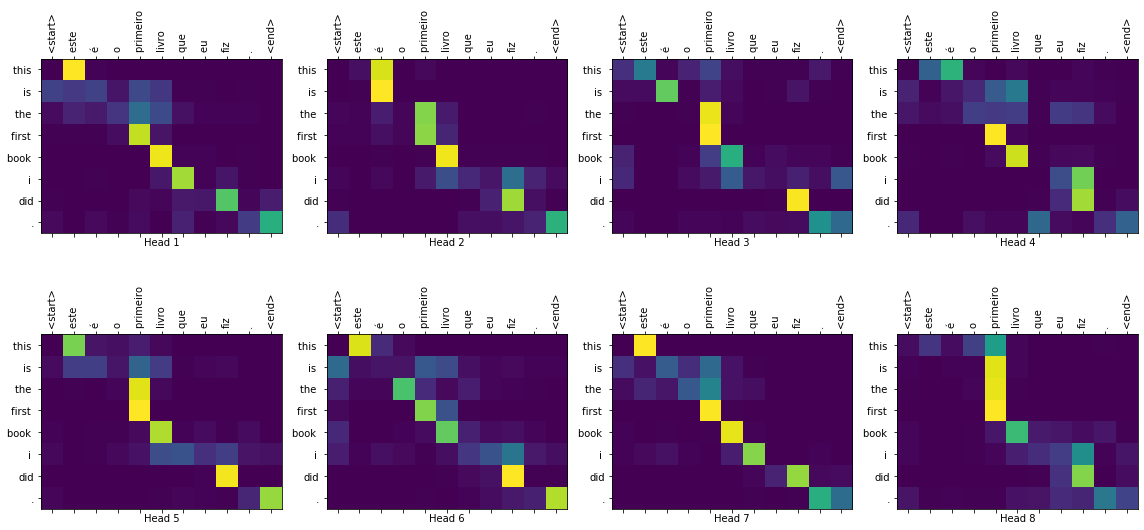

Real translation: this is the first book i've ever done.


In [64]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")

# 끝!